In [1]:
%pip install torch

Note: you may need to restart the kernel to use updated packages.


In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import math


class SelfAttention(nn.Module):
  def __init__(self, k, heads=8):
    super().__init__()
    self.k, self.heads = k, heads

    self.tokeys = nn.Linear(k, k * heads, bias=False)
    self.toqueries = nn.Linear(k, k * heads, bias=False)
    self.tovalues = nn.Linear(k, k * heads, bias=False)

    self.unifyheads = nn.Linear(heads * k, k)

  def forward(self, x):
    b, t, _ = x.size()
    h = self.heads
    k = self.k  

    queries = self.toqueries(x).view(b, t, h, k)
    keys = self.tokeys(x).view(b, t, h, k)
    values = self.tovalues(x).view(b, t, h, k)

    # (b, h, t, k)
    queries = queries.transpose(1, 2)
    keys = keys.transpose(1, 2)
    values = values.transpose(1, 2)

    dot = torch.matmul(queries, keys.transpose(2, 3)) / math.sqrt(k)
    dot = F.softmax(dot, dim=-1)
    out = torch.matmul(dot, values)
    out = out.transpose(1, 2).contiguous().view(b, t, h * k)
    return self.unifyheads(out)

In [2]:
class TransformerBlock(nn.Module):
    def __init__(self, k, heads):
        super().__init__()

        self.attention = SelfAttention(k, heads=heads)
        self.norm1 = nn.LayerNorm(k)
        self.norm2 = nn.LayerNorm(k)
        self.ff = nn.Sequential(
            nn.Linear(k, 4 * k),
            nn.ReLU(),
            nn.Linear(4 * k, k)
        )

    def forward(self, x):
        attended = self.attention(x)
        x = self.norm1(attended + x)

        fedforward = self.ff(x)
        return self.norm2(fedforward + x)

In [4]:
class Transformer(nn.Module):
  def __init__(self, k, heads, depth, seq_length, num_tokens):
        super().__init__()

        self.num_tokens = num_tokens
        self.token_emb = nn.Embedding(num_tokens, k)
        self.pos_emb = nn.Embedding(seq_length, k)

        tblocks = []
        for i in range(depth):
          tblocks.append(TransformerBlock(k=k, heads=heads))
        self.tblocks = nn.Sequential(*tblocks)

        # self.toprobs = nn.Linear(k, num_classes)
        self.to_logits = nn.Linear(k, num_tokens)

  def forward(self, x):
        tokens = self.token_emb(x)
        b, t, k = tokens.size()

        positions = torch.arange(t)
        positions = self.pos_emb(positions)[None, :, :].expand(b, t, k)

        x = tokens + positions
        x = self.tblocks(x)

        # x = self.toprobs(x.mean(dim=1))
        # return F.log_softmax(x, dim=1)
        logits = self.to_logits(x)  # (batch, seq_len, vocab_size)
        return logits


In [5]:
! pip install transformers

In [6]:
! pip install jupyterlab==3.6.7

In [6]:
import os
from transformers import AutoTokenizer
import torch


tokenizer = AutoTokenizer.from_pretrained("sberbank-ai/rugpt3small_based_on_gpt2")

path = "corpus"

texts = []
for fn in os.listdir(path):
    with open(os.path.join(path, fn), "r", encoding="utf-8") as f:
        texts.append(f.read())

# full_text = "\n".join(texts)

tokens = tokenizer(texts, return_tensors="pt", truncation=True, padding=True)

max_length = 512 

input_ids = tokens["input_ids"]

print(input_ids.shape)

chunks = [input_ids[:, i:i + max_length] for i in range(0, input_ids.shape[1], max_length)]

dataset = torch.utils.data.TensorDataset(torch.cat(chunks))

torch.Size([108, 2048])


In [8]:
from sklearn.model_selection import train_test_split

test_size = 0.2

all_data = dataset.tensors[0]

train_data, test_data = train_test_split(all_data, test_size=test_size, random_state=42)

train_dataset = torch.utils.data.TensorDataset(train_data)
test_dataset = torch.utils.data.TensorDataset(test_data)

print(f"Train size: {len(train_dataset)}")
print(f"Test size: {len(test_dataset)}")

Train size: 345
Test size: 87


In [9]:
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [7]:
model = Transformer(
    k=512,       
    heads=8,      
    depth=6,      
    seq_length=512,  
    num_tokens=tokenizer.vocab_size  
)


Testing Epoch 1: 100%|████████████████████████████████████████████████████████████████| 6/6 [01:14<00:00, 12.38s/batch]


Epoch 1: Train Loss = 7.0017, Test Loss = 5.7116


Testing Epoch 2: 100%|████████████████████████████████████████████████████████████████| 6/6 [01:13<00:00, 12.17s/batch]


Epoch 2: Train Loss = 4.7278, Test Loss = 4.4204


Testing Epoch 3: 100%|████████████████████████████████████████████████████████████████| 6/6 [01:15<00:00, 12.51s/batch]


Epoch 3: Train Loss = 3.5562, Test Loss = 3.5734


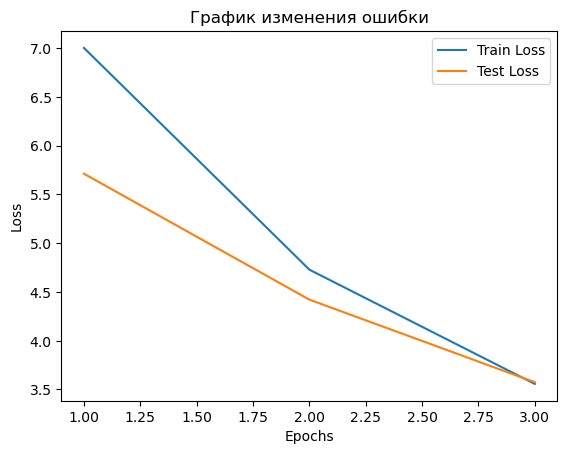

In [13]:
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tqdm import tqdm  

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 3
batch_size = 16
learning_rate = 3e-4

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

train_losses = []
test_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0

    for batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}", unit="batch"):
        batch = batch[0].to(device)  
    
        optimizer.zero_grad()
        logits = model(batch)
        
        # Ошибка
        loss = criterion(logits.view(-1, logits.size(-1)), batch.view(-1))
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    test_loss = 0

    with torch.no_grad():
        for batch in tqdm(test_loader, desc=f"Testing Epoch {epoch+1}", unit="batch"):
            batch = batch[0].to(device)
            logits = model(batch)
            
            loss = criterion(logits.view(-1, logits.size(-1)), batch.view(-1))
            test_loss += loss.item()

    avg_test_loss = test_loss / len(test_loader)
    test_losses.append(avg_test_loss)

    print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Test Loss = {avg_test_loss:.4f}")

plt.plot(range(1, num_epochs+1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs+1), test_losses, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("График изменения ошибки")
plt.show()


Testing Epoch 4: 100%|████████████████████████████████████████████████████████████████| 6/6 [01:15<00:00, 12.58s/batch]


Epoch 4: Train Loss = 2.7407, Test Loss = 2.9516


Testing Epoch 5: 100%|████████████████████████████████████████████████████████████████| 6/6 [01:16<00:00, 12.75s/batch]


Epoch 5: Train Loss = 2.0954, Test Loss = 2.4761


Testing Epoch 6: 100%|████████████████████████████████████████████████████████████████| 6/6 [01:15<00:00, 12.51s/batch]


Epoch 6: Train Loss = 1.5966, Test Loss = 2.1043


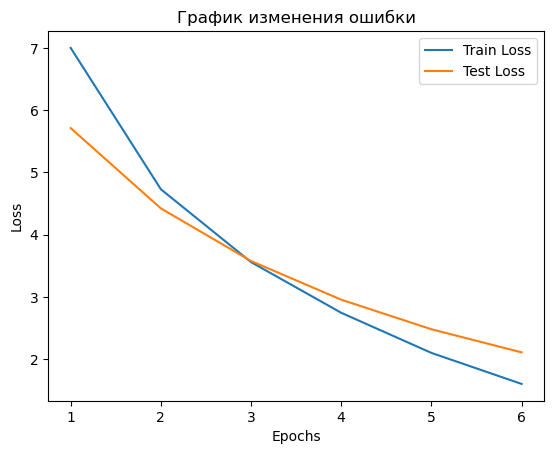

In [40]:
prev_epoch = 3
num_epochs = 6

for epoch in range(prev_epoch, num_epochs):
    model.train()
    train_loss = 0

    for batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}", unit="batch"):
        batch = batch[0].to(device)  
    
        optimizer.zero_grad()
        logits = model(batch)
        
        loss = criterion(logits.view(-1, logits.size(-1)), batch.view(-1))
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    test_loss = 0

    with torch.no_grad():
        for batch in tqdm(test_loader, desc=f"Testing Epoch {epoch+1}", unit="batch"):
            batch = batch[0].to(device)
            logits = model(batch)
            
            loss = criterion(logits.view(-1, logits.size(-1)), batch.view(-1))
            test_loss += loss.item()

    avg_test_loss = test_loss / len(test_loader)
    test_losses.append(avg_test_loss)

    print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Test Loss = {avg_test_loss:.4f}")

plt.plot(range(1, num_epochs+1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs+1), test_losses, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("График изменения ошибки")
plt.show()

In [8]:
def generate(model, input, max_new_tokens=5):
    for _ in range(max_new_tokens):
        logits = model.forward(input)  # (b, t, vocab_size)
        probs = F.softmax(logits[:, -1, :], dim=-1)  
        next_token = torch.multinomial(probs, num_samples=1)
        input = torch.cat([input, next_token], dim=1)
    return input

In [9]:
model.load_state_dict(torch.load("transformer_weights.pth"))

<All keys matched successfully>

In [16]:
model.eval()
context = tokenizer("Темный лес", return_tensors="pt")["input_ids"].to("cpu")
generated = generate(model, context, max_new_tokens=6)

print(tokenizer.decode(generated[0], skip_special_tokens=True))

Темный лес неп Андреев Наслед добавляетрую протя


In [51]:
model_path = "transformer_weights.pth"

torch.save(model.state_dict(), model_path)
print(f"Модель сохранена в {model_path}")

Модель сохранена в transformer_weights.pth
